In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn import preprocessing
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

In [2]:
path_data = 'data/Economy_Data.csv'
path_target = 'data/HealthAndPoverty_Data.csv'

X = pd.read_csv(path_data, sep=';')
y = pd.read_csv(path_target, sep=';')

# Limpando dados

In [3]:
X = X[~X['Value'].isna()] # dropping all rows with NaN values
y = y[~y['Value'].isna()] # dropping all rows with NaN values

In [4]:
X['SeriesName']

5        Adjusted net national income (constant 2010 US$)
7        Adjusted net national income (constant 2010 US$)
10             Adjusted net national income (current US$)
11             Adjusted net national income (current US$)
12             Adjusted net national income (current US$)
                               ...                       
86490                Use of IMF credit (DOD, current US$)
86491                Use of IMF credit (DOD, current US$)
86492                Use of IMF credit (DOD, current US$)
86493                Use of IMF credit (DOD, current US$)
86494                Use of IMF credit (DOD, current US$)
Name: SeriesName, Length: 60348, dtype: object

## Primeira ideia:
* Feature selection (ver a coluna Series Name - pra depois agrupamento por ano)

## Nova ideia:
* Utilizar os dados em X pra prever cada `SeriesName` de forma separada.
* Aparentemente ha poucos em Y


## ATENCAO 
Adicionei abaixo  uma transformacao das features em onehot, mas ainda nao sei como combinar todas no agg (talvez eu mantenha em sum)

In [5]:
X.head()

,SeriesName,SeriesCode,CountryName,CountryCode,Year,Value
5,Adjusted net national income (constant 2010 US$),NY.ADJ.NNTY.KD,Brazil,BRA,1970.0,3.918974e+11
7,Adjusted net national income (constant 2010 US$),NY.ADJ.NNTY.KD,India,IND,1970.0,1.915335e+11
10,Adjusted net national income (current US$),NY.ADJ.NNTY.CD,Brazil,BRA,1970.0,3.786021e+10
11,Adjusted net national income (current US$),NY.ADJ.NNTY.CD,China,CHN,1970.0,8.525561e+10
12,Adjusted net national income (current US$),NY.ADJ.NNTY.CD,India,IND,1970.0,5.776720e+10


>- Como ideia aqui sugiro contar o número de análises que foram aplicadas aos países. Contar a incidência de dummies para cada ano, e a partir daí ver a evolução das análises empregadas ao longo do tempo.
>- Outra ideia seria montar um dataframe único onde são agregados os dados de `X` e `y`, cruzando indices históricos de cada nação afim de definir possíveis relações entre as variáveis.

## Resultados
* Ficou horrivel o regressor dessa forma (talvez tenhamos que fazer de maneiras mais simples), e.g.:
    - selecionar um `SeriesName` de X e um de y e criar uma hipotese em cima

## África do Sul
---

In [6]:
X_zaf = X[X['CountryCode'] == 'ZAF'].copy()

In [7]:
y_zaf = y[y['CountryCode'] == 'ZAF'].copy()

In [8]:
infant_deaths = y_zaf[y_zaf['SeriesName'] == 'Number of infant deaths'].copy()
gva = X_zaf[X_zaf['SeriesName'] ==  'Gross value added at basic prices (GVA) (current US$)']

In [9]:
norm = preprocessing.MinMaxScaler()
infant_deaths_norm = infant_deaths['Value'].values
infant_deaths_norm = norm.fit_transform(infant_deaths_norm.reshape(-1,1))

gva_norm  = gva['Value'].values
gva_norm = norm.fit_transform(gva_norm.reshape(-1,1))

infant_deaths['norm'] = infant_deaths_norm
gva['norm'] = gva_norm

/home/coutinho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [10]:
fig = go.Figure()
fig.add_trace(go.Bar(x = infant_deaths['Year'], y = infant_deaths['norm'], name= 'infant_deaths', hovertemplate="Deaths: %{y}<extra></extra>"))
fig.add_trace(go.Bar(x = gva['Year'], y = gva['norm'], name= 'GVA'))

In [11]:
gva = gva.merge(infant_deaths, on = 'Year', how = 'right')

hipot_X = gva['Value_y'].iloc[:]
hipot_y = gva['Value_x'].iloc[:]

hipot_X = hipot_X.reset_index(drop=True)
hipot_y = hipot_y.reset_index(drop=True)

est = sm.OLS(hipot_y, hipot_X)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                Value_x   R-squared (uncentered):                   0.521
Model:                            OLS   Adj. R-squared (uncentered):              0.510
Method:                 Least Squares   F-statistic:                              47.87
Date:                Thu, 29 Jul 2021   Prob (F-statistic):                    1.50e-08
Time:                        22:17:59   Log-Likelihood:                         -1217.0
No. Observations:                  45   AIC:                                      2436.
Df Residuals:                      44   BIC:                                      2438.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [12]:
working_age = y_zaf[y_zaf['SeriesName'] == 'Age dependency ratio, young (% of working-age population)'].copy()
gni_pcapita_growth = X_zaf[X_zaf['SeriesName'] == 'GNI per capita growth (annual %)']

In [13]:
working_age = working_age.merge(gni_pcapita_growth, on = 'Year', how = 'right')
working_age.head()

,SeriesName_x,SeriesCode_x,CountryName_x,CountryCode_x,Year,Value_x,SeriesName_y,SeriesCode_y,CountryName_y,CountryCode_y,Value_y
0,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,South Africa,ZAF,1970.0,75.990436,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,South Africa,ZAF,2.504601
1,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,South Africa,ZAF,1971.0,75.886248,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,South Africa,ZAF,1.896106
2,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,South Africa,ZAF,1972.0,75.756590,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,South Africa,ZAF,-1.174019
3,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,South Africa,ZAF,1973.0,75.584615,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,South Africa,ZAF,1.703489
4,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,South Africa,ZAF,1974.0,75.301842,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,South Africa,ZAF,3.106308


In [14]:
hipot_X = working_age['Value_x'].iloc[:]
hipot_y = working_age['Value_y'].iloc[:]

hipot_X = hipot_X.reset_index(drop=True)
hipot_y = hipot_y.reset_index(drop=True)

est = sm.OLS(hipot_y, hipot_X)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                Value_y   R-squared (uncentered):                   0.016
Model:                            OLS   Adj. R-squared (uncentered):             -0.004
Method:                 Least Squares   F-statistic:                             0.8072
Date:                Thu, 29 Jul 2021   Prob (F-statistic):                       0.373
Time:                        22:18:00   Log-Likelihood:                         -110.99
No. Observations:                  50   AIC:                                      224.0
Df Residuals:                      49   BIC:                                      225.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Rússia
---

In [15]:

X_rus = X[X['CountryCode'] == 'RUS'].copy()

y_rus = y[y['CountryCode'] == 'RUS'].copy()

infant_deaths = y_rus[y_rus['SeriesName'] == 'Number of infant deaths'].copy()
gva = X_rus[X_rus['SeriesName'] ==  'Gross value added at basic prices (GVA) (current US$)']

norm = preprocessing.MinMaxScaler()
infant_deaths_norm = infant_deaths['Value'].values
infant_deaths_norm = norm.fit_transform(infant_deaths_norm.reshape(-1,1))

gva_norm  = gva['Value'].values
gva_norm = norm.fit_transform(gva_norm.reshape(-1,1))

infant_deaths['norm'] = infant_deaths_norm
gva['norm'] = gva_norm

fig = go.Figure()
fig.add_trace(go.Bar(x = infant_deaths['Year'], y = infant_deaths['norm'], name= 'infant_deaths', hovertemplate="Deaths: %{y}<extra></extra>"))
fig.add_trace(go.Bar(x = gva['Year'], y = gva['norm'], name= 'GVA'))


/home/coutinho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
gva = gva.merge(infant_deaths, on = 'Year', how = 'left')

hipot_X = gva['Value_x'].iloc[:]
hipot_y = gva['Value_y'].iloc[:]

hipot_X = hipot_X.reset_index(drop=True)
hipot_y = hipot_y.reset_index(drop=True)

est = sm.OLS(hipot_y, hipot_X)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                Value_y   R-squared (uncentered):                   0.410
Model:                            OLS   Adj. R-squared (uncentered):              0.390
Method:                 Least Squares   F-statistic:                              20.85
Date:                Thu, 29 Jul 2021   Prob (F-statistic):                    7.91e-05
Time:                        22:18:01   Log-Likelihood:                         -346.07
No. Observations:                  31   AIC:                                      694.1
Df Residuals:                      30   BIC:                                      695.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [17]:
working_age = y_rus[y_rus['SeriesName'] == 'Age dependency ratio, young (% of working-age population)'].copy()
gni_pcapita_growth = X_rus[X_rus['SeriesName'] == 'GNI per capita growth (annual %)']
working_age = working_age.merge(gni_pcapita_growth, on = 'Year', how = 'right')
working_age.head()

,SeriesName_x,SeriesCode_x,CountryName_x,CountryCode_x,Year,Value_x,SeriesName_y,SeriesCode_y,CountryName_y,CountryCode_y,Value_y
0,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,Russian Federation,RUS,1991.0,34.326630,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,Russian Federation,RUS,-5.401840
1,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,Russian Federation,RUS,1992.0,34.054629,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,Russian Federation,RUS,-15.338124
2,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,Russian Federation,RUS,1993.0,33.538935,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,Russian Federation,RUS,-8.522069
3,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,Russian Federation,RUS,1994.0,32.890149,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,Russian Federation,RUS,-12.016198
4,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,Russian Federation,RUS,1995.0,32.158723,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,Russian Federation,RUS,-4.475053


In [18]:
hipot_X = working_age['Value_x'].iloc[:]
hipot_y = working_age['Value_y'].iloc[:]

hipot_X = hipot_X.reset_index(drop=True)
hipot_y = hipot_y.reset_index(drop=True)

est = sm.OLS(hipot_y, hipot_X)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                Value_y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.035
Method:                 Least Squares   F-statistic:                           0.008909
Date:                Thu, 29 Jul 2021   Prob (F-statistic):                       0.925
Time:                        22:18:01   Log-Likelihood:                         -96.090
No. Observations:                  29   AIC:                                      194.2
Df Residuals:                      28   BIC:                                      195.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## India
---

In [19]:
X_ind = X[X['CountryCode'] == 'IND'].copy()

In [20]:
y_ind = y[y['CountryCode'] == 'IND'].copy()

In [21]:
infant_deaths = y_ind[y_ind['SeriesName'] == 'Number of infant deaths'].copy()
gva = X_ind[X_ind['SeriesName'] ==  'Gross value added at basic prices (GVA) (current US$)']

In [22]:
norm = preprocessing.MinMaxScaler()
infant_deaths_norm = infant_deaths['Value'].values
infant_deaths_norm = norm.fit_transform(infant_deaths_norm.reshape(-1,1))

gva_norm  = gva['Value'].values
gva_norm = norm.fit_transform(gva_norm.reshape(-1,1))

infant_deaths['norm'] = infant_deaths_norm
gva['norm'] = gva_norm

/home/coutinho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
fig = go.Figure()
fig.add_trace(go.Bar(x = infant_deaths['Year'], y = infant_deaths['norm'], name= 'infant_deaths', hovertemplate="Deaths: %{y}<extra></extra>"))
fig.add_trace(go.Bar(x = gva['Year'], y = gva['norm'], name= 'GVA'))

In [24]:
gva = gva.merge(infant_deaths, on = 'Year', how = 'right')

hipot_X = gva['Value_y'].iloc[:]
hipot_y = gva['Value_x'].iloc[:]

hipot_X = hipot_X.reset_index(drop=True)
hipot_y = hipot_y.reset_index(drop=True)

est = sm.OLS(hipot_y, hipot_X)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                Value_x   R-squared (uncentered):                   0.164
Model:                            OLS   Adj. R-squared (uncentered):              0.147
Method:                 Least Squares   F-statistic:                              9.599
Date:                Thu, 29 Jul 2021   Prob (F-statistic):                     0.00322
Time:                        22:18:03   Log-Likelihood:                         -1447.8
No. Observations:                  50   AIC:                                      2898.
Df Residuals:                      49   BIC:                                      2900.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [25]:
working_age = y_ind[y_ind['SeriesName'] == 'Age dependency ratio, young (% of working-age population)'].copy()
gni_pcapita_growth = X_ind[X_ind['SeriesName'] == 'GNI per capita growth (annual %)']

In [26]:
working_age = working_age.merge(gni_pcapita_growth, on = 'Year', how = 'right')
working_age.head()

,SeriesName_x,SeriesCode_x,CountryName_x,CountryCode_x,Year,Value_x,SeriesName_y,SeriesCode_y,CountryName_y,CountryCode_y,Value_y
0,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,India,IND,1970.0,73.345444,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,India,IND,2.889157
1,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,India,IND,1971.0,73.026750,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,India,IND,-0.601199
2,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,India,IND,1972.0,72.651510,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,India,IND,-2.794701
3,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,India,IND,1973.0,72.216856,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,India,IND,0.978327
4,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,India,IND,1974.0,71.672525,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,India,IND,-1.018150


In [27]:
hipot_X = working_age['Value_x'].iloc[:]
hipot_y = working_age['Value_y'].iloc[:]

hipot_X = hipot_X.reset_index(drop=True)
hipot_y = hipot_y.reset_index(drop=True)

est = sm.OLS(hipot_y, hipot_X)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                Value_y   R-squared (uncentered):                   0.502
Model:                            OLS   Adj. R-squared (uncentered):              0.492
Method:                 Least Squares   F-statistic:                              49.33
Date:                Thu, 29 Jul 2021   Prob (F-statistic):                    6.10e-09
Time:                        22:18:03   Log-Likelihood:                         -129.49
No. Observations:                  50   AIC:                                      261.0
Df Residuals:                      49   BIC:                                      262.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Brasil
---

In [28]:
X_br = X[X['CountryCode'] == 'BRA'].copy()

In [29]:
y_br = y[y['CountryCode'] == 'BRA'].copy()

In [30]:
y_br

,SeriesName,SeriesCode,CountryName,CountryCode,Year,Value
0,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,Brazil,BRA,1970.0,77.118400
15,Age dependency ratio (% of working-age populat...,SP.POP.DPND,Brazil,BRA,1970.0,83.980449
20,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,Brazil,BRA,1970.0,6.318839
25,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,Brazil,BRA,1970.0,77.661610
55,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,Brazil,BRA,1970.0,35.116000
...,...,...,...,...,...,...
69210,"Prevalence of HIV, total (% of population ages...",SH.DYN.AIDS.ZS,Brazil,BRA,2019.0,0.500000
69305,Probability of dying among adolescents ages 10...,SH.DYN.1014,Brazil,BRA,2019.0,1.400000
69310,Probability of dying among adolescents ages 15...,SH.DYN.1519,Brazil,BRA,2019.0,5.800000
69315,Probability of dying among children ages 5-9 y...,SH.DYN.0509,Brazil,BRA,2019.0,1.000000


In [31]:
test = y_br['SeriesName'].value_counts()
test2 = X_br['SeriesName'].value_counts()

In [32]:
test[test >= 50].index

Index(['Mortality rate, infant (per 1,000 live births)',
       'Population ages 50-54, female (% of female population)',
       'Population ages 60-64, female (% of female population)',
       'Mortality rate, infant, male (per 1,000 live births)',
       'Population ages 00-04, female (% of female population)',
       'Population ages 65 and above, total',
       'Population ages 50-54, male (% of male population)',
       'Population ages 25-29, female (% of female population)',
       'Mortality rate, infant, female (per 1,000 live births)',
       'Age dependency ratio, old (% of working-age population)',
       'Age dependency ratio (% of working-age population)',
       'Population ages 70-74, female (% of female population)',
       'Population ages 65 and above, male (% of male population)',
       'Population ages 65 and above, female',
       'Population ages 70-74, male (% of male population)',
       'Population ages 15-19, female (% of female population)',
       'Mortali

In [33]:
#X_br['SeriesName'].unique()[X_br['SeriesName'].unique().apply(lambda x: 'Adjusted' in x)]

X_br['SeriesName'][X_br['SeriesName'].apply(lambda x: 'per capita' in x)].unique()

array(['Adjusted net national income per capita (constant 2010 US$)',
       'Adjusted net national income per capita (current US$)',
       'GDP per capita (constant 2010 US$)',
       'GDP per capita (constant LCU)', 'GDP per capita (current LCU)',
       'GDP per capita (current US$)', 'GDP per capita growth (annual %)',
       'GNI per capita (constant 2010 US$)',
       'GNI per capita (constant LCU)', 'GNI per capita (current LCU)',
       'GNI per capita, Atlas method (current US$)',
       'Households and NPISHs Final consumption expenditure per capita (constant 2010 US$)',
       'Households and NPISHs Final consumption expenditure per capita growth (annual %)',
       'Net ODA received per capita (current US$)',
       'Adjusted net national income per capita (annual % growth)',
       'GNI per capita growth (annual %)',
       'GDP per capita, PPP (constant 2017 international $)',
       'GDP per capita, PPP (current international $)',
       'GNI per capita, PPP (constant 2

In [34]:
test2[test2 >= 50].index

Index(['Short-term debt (% of total external debt)',
       'Use of IMF credit (DOD, current US$)',
       'Households and NPISHs Final consumption expenditure per capita (constant 2010 US$)',
       'Imports of goods and services (% of GDP)',
       'General government final consumption expenditure (constant LCU)',
       'Taxes less subsidies on products (current US$)',
       'Imports of goods and services (constant LCU)',
       'Short-term debt (% of total reserves)',
       'Services, value added (current LCU)',
       'Exports of goods and services (annual % growth)',
       ...
       'Exports as a capacity to import (constant LCU)',
       'Agriculture, forestry, and fishing, value added (constant 2010 US$)',
       'Industry (including construction), value added (constant 2010 US$)',
       'Agriculture, forestry, and fishing, value added (constant LCU)',
       'Net financial flows, RDB nonconcessional (NFL, current US$)',
       'Gross national expenditure (current US$)',
 

In [35]:
cobert_hiv_treatment = y_br[y_br['SeriesName'] == 'Antiretroviral therapy coverage (% of people living with HIV)']

In [36]:
gva = X_br[X_br['SeriesName'] ==  'Gross value added at basic prices (GVA) (current US$)']


In [37]:
gva.head()

,SeriesName,SeriesCode,CountryName,CountryCode,Year,Value
775,Gross value added at basic prices (GVA) (curre...,NY.GDP.FCST.CD,Brazil,BRA,1970.0,3.556752e+10
2505,Gross value added at basic prices (GVA) (curre...,NY.GDP.FCST.CD,Brazil,BRA,1971.0,4.214448e+10
4235,Gross value added at basic prices (GVA) (curre...,NY.GDP.FCST.CD,Brazil,BRA,1972.0,4.986391e+10
5965,Gross value added at basic prices (GVA) (curre...,NY.GDP.FCST.CD,Brazil,BRA,1973.0,6.793320e+10
7695,Gross value added at basic prices (GVA) (curre...,NY.GDP.FCST.CD,Brazil,BRA,1974.0,9.137394e+10


In [38]:
working_age = y_br[y_br['SeriesName'] == 'Age dependency ratio, young (% of working-age population)'].copy()

In [39]:
infant_deaths = y_br[y_br['SeriesName'] == 'Number of infant deaths'].copy()

In [40]:
gni_pcapita_growth = X_br[X_br['SeriesName'] == 'GNI per capita growth (annual %)']

In [41]:
gni_per_capita = X_br[X_br['SeriesName'] == 'GNI per capita, PPP (constant 2017 international $)'].copy()

In [42]:
norm = preprocessing.MinMaxScaler()

In [43]:
infant_deaths_norm = infant_deaths['Value'].values
infant_deaths_norm = norm.fit_transform(infant_deaths_norm.reshape(-1,1))

gva_norm  = gva['Value'].values
gva_norm = norm.fit_transform(gva_norm.reshape(-1,1))

In [44]:
infant_deaths['norm'] = infant_deaths_norm
gva['norm'] = gva_norm

/home/coutinho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
fig = go.Figure()
fig.add_trace(go.Bar(x = infant_deaths['Year'], y = infant_deaths['norm'], name= 'infant_deaths', hovertemplate="Deaths: %{y}<extra></extra>"))
fig.add_trace(go.Bar(x = gva['Year'], y = gva['norm'], name= 'GVA'))
fig.add_trace(go.Bar(x = cobert_hiv_treatment['Year'], y = cobert_hiv_treatment['Value']/100, name = 'HIV coverage',hovertemplate = 'Coverage: %{y}<extra></extra>'))

In [46]:
working_age = working_age.merge(gni_pcapita_growth, on = 'Year', how = 'right')

In [47]:
working_age.head()

,SeriesName_x,SeriesCode_x,CountryName_x,CountryCode_x,Year,Value_x,SeriesName_y,SeriesCode_y,CountryName_y,CountryCode_y,Value_y
0,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,Brazil,BRA,1971.0,76.588746,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,Brazil,BRA,8.975421
1,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,Brazil,BRA,1972.0,75.482549,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,Brazil,BRA,9.670938
2,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,Brazil,BRA,1973.0,74.318919,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,Brazil,BRA,10.937734
3,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,Brazil,BRA,1974.0,73.061335,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,Brazil,BRA,6.901292
4,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,Brazil,BRA,1975.0,71.724512,GNI per capita growth (annual %),NY.GNP.PCAP.KD.ZG,Brazil,BRA,2.177873


In [48]:
import statsmodels.api as sm
from scipy import stats

hipot_X = infant_deaths['Value'].iloc[:]
hipot_y = gva['Value'].iloc[:]

hipot_X = hipot_X.reset_index(drop=True)
hipot_y = hipot_y.reset_index(drop=True)

est = sm.OLS(hipot_y, hipot_X)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Value   R-squared (uncentered):                   0.108
Model:                            OLS   Adj. R-squared (uncentered):              0.090
Method:                 Least Squares   F-statistic:                              5.944
Date:                Thu, 29 Jul 2021   Prob (F-statistic):                      0.0184
Time:                        22:18:09   Log-Likelihood:                         -1448.2
No. Observations:                  50   AIC:                                      2898.
Df Residuals:                      49   BIC:                                      2900.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

>- A partir dessas informações é possivel refutar a hipotese nula;

<AxesSubplot:xlabel='Value', ylabel='Value'>

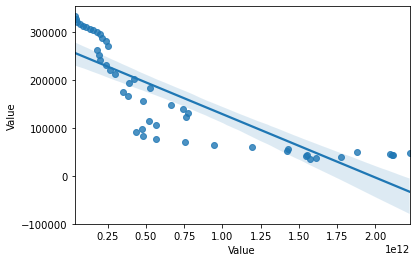

In [49]:
sns.regplot(x = gva['Value'], y = infant_deaths['Value'])